# Pipeline A

- Imputation
- Feature engineering (Ratios, aggregation)
- Standardization (min-max)
- Normalization
- Binning and Re-coding
- Feature Selection
- Modeling

In [1]:
# for preprocessing/eda models
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import kurtosis, skew
import math
from scipy.stats import norm

# feature selection
from sklearn.feature_selection import RFE

# balancing
from imblearn.over_sampling import SMOTE

# accuracy metrics and data split models
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', 500) # display max 500 rows
pd.set_option('display.max_rows', 140)

Using TensorFlow backend.


In [2]:
# read in data to skip innitial steps from pipeline B
data = pd.read_csv('online_shoppers_intention-2.csv')
data1 = data.copy() # copy of original df
data1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
data1.Weekend.value_counts()

False    9462
True     2868
Name: Weekend, dtype: int64

## Imputation 
- assumption that exit rates cannot be zero

In [4]:
# impute our assumption (beccomes a new feature)
data1['ExitRatesImpute'] = data1['ExitRates'].replace(0,np.NaN)
data1['ExitRatesImpute'] = data1['ExitRatesImpute'].fillna(data1['ExitRatesImpute'].median())

## Feature Engineering (Ratios, aggregation)
- calculate ratios for count of page visits 
- combine bounce and exit rates (average and weighted average - new features)
    - they have a strong linear relationship
- divide features that have strong non-linear relationship 
    - solve zero-division by replacing it with 0 (e.g. 1/0 = n/a)

In [5]:
# ratios for counts
data1['totalFracAdmin'] = data1['Administrative']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])
data1['totalFracInfo'] = data1['Informational']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])
data1['totalFracProd'] = data1['ProductRelated']/(data1['Administrative'] + data1['Informational'] + data1['ProductRelated'])

# average combining
data1['BounceExitAvg'] = (data1['BounceRates'] + data1['ExitRates'])/2

# weighted-average feature joining
data1['BounceExitW1'] = data1['BounceRates'] * 0.6 + data1['ExitRates'] * 0.4
data1['BounceExitW2'] = data1['BounceRates'] * 0.7 + data1['ExitRates'] * 0.3
data1['BounceExitW3'] = data1['BounceRates'] * 0.4 + data1['ExitRates'] * 0.6
data1['BounceExitW4'] = data1['BounceRates'] * 0.3 + data1['ExitRates'] * 0.7

# bounce and exit rates vs page values ratio 
data1['BouncePageRatio'] = data1['BounceRates']/data1['PageValues']
data1['ExitPageRatio'] = data1['ExitRates']/data1['PageValues']

# durations vs page values, bounce and exit rates
data1['InfoPageRatio'] = data1['Informational_Duration']/data1['PageValues']
data1['ProdRelPageRatio'] = data1['ProductRelated_Duration']/data1['PageValues']
data1['InfoBounceRatio'] = data1['Informational_Duration']/data1['BounceRates']
data1['AdminBounceRatio'] = data1['Administrative_Duration']/data1['BounceRates']
data1['ProdRelBounceRatio'] = data1['ProductRelated_Duration']/data1['BounceRates']
data1['InfoExitRatio'] = data1['Informational_Duration']/data1['ExitRates']
data1['AdminBounceRatio'] = data1['Administrative_Duration']/data1['ExitRates']
data1['ProdRelExitRatio'] = data1['ProductRelated_Duration']/data1['ExitRates']

# page values, bounce and exit rates vs durations
#data1['PageInfoRatio'] = data1['PageValues']/data1['Informational_Duration']
#data1['PageProdRelRatio'] = data1['PageValues']/data1['ProductRelated_Duration']
#data1['BounceInfoRatio'] = data1['BounceRates']/data1['Informational_Duration']
#data1['BounceAdminRatio'] = data1['BounceRates']/data1['Administrative_Duration']
#data1['BounceProdRelRatio'] = data1['BounceRates']/data1['ProductRelated_Duration']
#data1['ExitInfoRatio'] = data1['ExitRates']/data1['Informational_Duration']
#data1['BounceAdminRatio'] = data1['ExitRates']/data1['Administrative_Duration']
#data1['ExitProdRelRatio'] = data1['ExitRates']/data1['ProductRelated_Duration']

# as there are many zero values --> e.g. x/0 (zero-division) = N/A or inf can occur 
# if there is zero-division treat that as a zero
data1 = data1.fillna(0) # fill N/A with 0 
data1 = data1.replace(np.inf, 0) # replace inf wit 0
data1 = data1.replace(-0, 0) # for some reason we also get -0 just fix it to 0 

In [6]:
print('Original number of features: ', len(data.columns))
print('Number of features added: ', len(data1.columns) - len(data.columns))
print('Total number of features after feature engineering: ', len(data1.columns) + len(data.columns))

Original number of features:  18
Number of features added:  18
Total number of features after feature engineering:  54


## Standardization

In [7]:
# make a copy
standardize = data1.copy()  
# select continous features (exclude Special Day)
standardize = standardize.select_dtypes(include='float64').drop('SpecialDay', axis = 1)

In [8]:
# import MinMaxScaler module
from sklearn.preprocessing import MinMaxScaler

# use MinMaxScaler function 
scaler = MinMaxScaler()

# min-max standerdize all continous columns
standardize[standardize.columns] = scaler.fit_transform(standardize[standardize.columns]) # fit the scaler to the model 
standardize_done = standardize.add_suffix('_Scaled') # add suffix (new features)

# add new standerdized features to data1
data1 = pd.concat([data1, standardize_done], axis = 1 )

#use .describe() to prove standardization worked
standardize_done.describe()

,Administrative_Duration_Scaled,Informational_Duration_Scaled,ProductRelated_Duration_Scaled,BounceRates_Scaled,ExitRates_Scaled,PageValues_Scaled,ExitRatesImpute_Scaled,totalFracAdmin_Scaled,totalFracInfo_Scaled,totalFracProd_Scaled,BounceExitAvg_Scaled,BounceExitW1_Scaled,BounceExitW2_Scaled,BounceExitW3_Scaled,BounceExitW4_Scaled,BouncePageRatio_Scaled,ExitPageRatio_Scaled,InfoPageRatio_Scaled,ProdRelPageRatio_Scaled,InfoBounceRatio_Scaled,AdminBounceRatio_Scaled,ProdRelBounceRatio_Scaled,InfoExitRatio_Scaled,ProdRelExitRatio_Scaled
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.00000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,0.023779,0.013522,0.018676,0.110957,0.215364,0.016279,0.215459,0.079955,0.01446,0.905098,0.163160,0.152720,0.142279,0.173601,0.184042,0.001512,0.001537,0.001563,0.000596,0.001190,0.001255,0.001096,0.005869,0.006603
std,0.052013,0.055209,0.029913,0.242442,0.242983,0.051328,0.242704,0.126751,0.05037,0.141883,0.237375,0.237535,0.238127,0.237646,0.238347,0.015647,0.013210,0.019200,0.012077,0.016869,0.011059,0.015312,0.030030,0.019537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.002878,0.000000,0.071429,0.000000,0.070613,0.000000,0.00000,0.860465,0.039532,0.033333,0.025805,0.046154,0.052593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000338
50%,0.002207,0.000000,0.009362,0.015562,0.125782,0.000000,0.126436,0.021661,0.00000,0.963359,0.079255,0.066667,0.056848,0.088884,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000,0.001863
75%,0.027438,0.000000,0.022887,0.084063,0.250000,0.000000,0.249341,0.115385,0.00000,1.000000,0.162709,0.140852,0.129167,0.175638,0.189772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000868,0.000268,0.000000,0.006279
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
print('Number of features before standardization: ', len(data1.columns) - len(standardize_done.columns))
print('Number of features added: ', len(standardize_done.columns))
print('Total number of features after standardization: ', len(data1.columns))

Number of features before standardization:  36
Number of features added:  24
Total number of features after standardization:  60


## Normalization
- Normalize continous values 
- Requirement: -0.5 < .skew() < 0.5

In [10]:
normalization_df = standardize_done.copy()

### Features that need to be Normalized
- Note: original features that were not scaled were added as well 

In [11]:
# find skewed features 
normalization_needed = [] # empty list for cols that need normalizing 
normalization_df_cols = normalization_df.columns
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        normalization_needed.append(col)
    elif normalization_df[col].skew() < -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        normalization_needed.append(col)
    else:
        ""

Right skew:  Administrative_Duration_Scaled 5.6157190187741906
Right skew:  Informational_Duration_Scaled 7.5791847157342165
Right skew:  ProductRelated_Duration_Scaled 7.2632276825613165
Right skew:  BounceRates_Scaled 2.9478552666955338
Right skew:  ExitRates_Scaled 2.1487889999009795
Right skew:  PageValues_Scaled 6.382964248998127
Right skew:  ExitRatesImpute_Scaled 2.1562028822830084
Right skew:  totalFracAdmin_Scaled 2.6021648114344162
Right skew:  totalFracInfo_Scaled 8.71792989818395
Left skew:  totalFracProd_Scaled -2.4188748873082173
Right skew:  BounceExitAvg_Scaled 2.658645853438436
Right skew:  BounceExitW1_Scaled 2.7432714016393325
Right skew:  BounceExitW2_Scaled 2.8163076932534996
Right skew:  BounceExitW3_Scaled 2.564778543858945
Right skew:  BounceExitW4_Scaled 2.4642333180311855
Right skew:  BouncePageRatio_Scaled 41.78940180771349
Right skew:  ExitPageRatio_Scaled 43.581820133212936
Right skew:  InfoPageRatio_Scaled 29.693954555446144
Right skew:  ProdRelPageRatio_S

In [12]:
print(len(normalization_needed),' features need normalizing')

24  features need normalizing


In [13]:
# function to create a histogram 
# source: https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data
def plot_hist(df, column, bin_amount=25):
    # Fit a normal distribution to the data:
    mu, std = norm.fit(df[column])

    # Plot the histogram.
    ## Set the alpha value used for blending (how transparent the color is)
    plt.hist(df[column], bins=bin_amount, density=True, alpha=0.8, color='g')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.xlabel(col)
    plt.show()

### Histograms for all features before normalization
- Some are highly skewed and might not be possible to normalize 

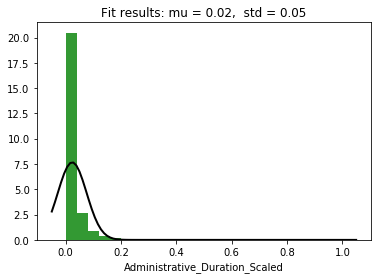

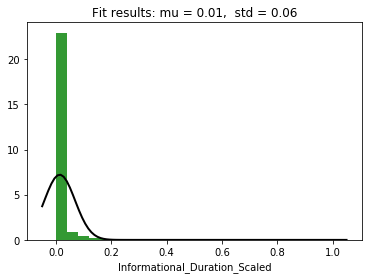

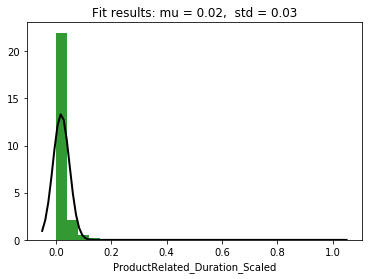

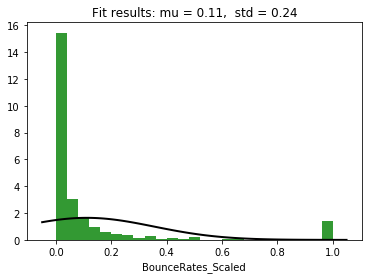

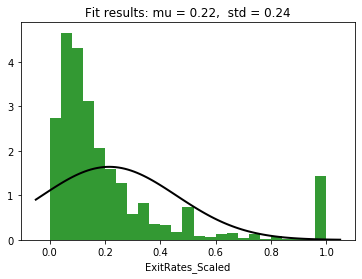

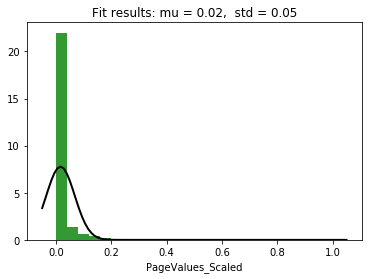

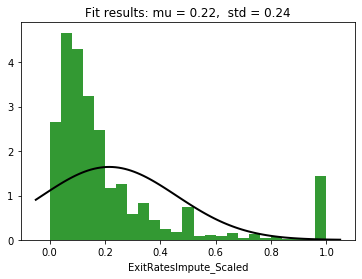

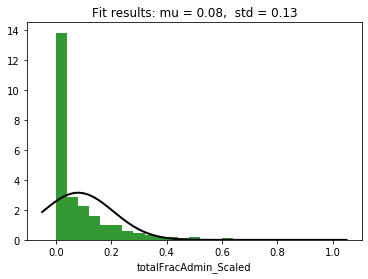

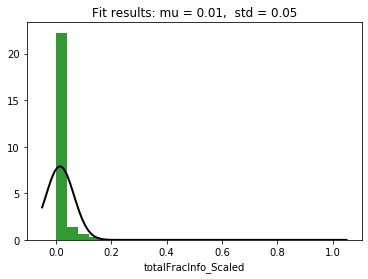

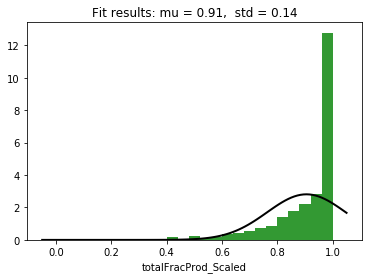

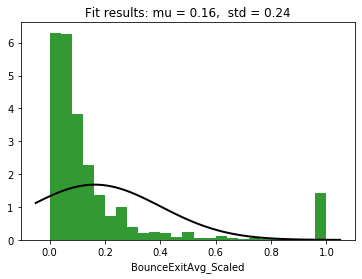

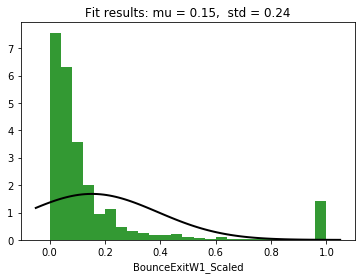

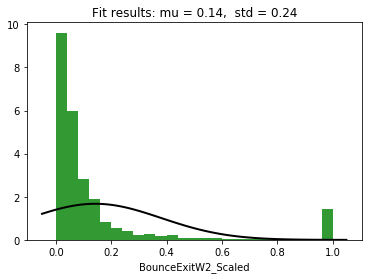

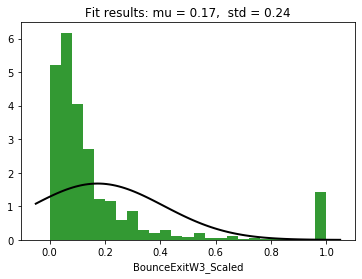

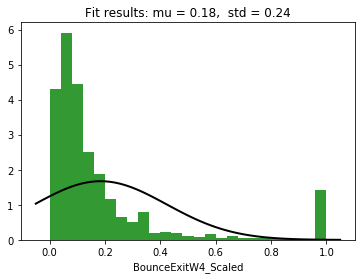

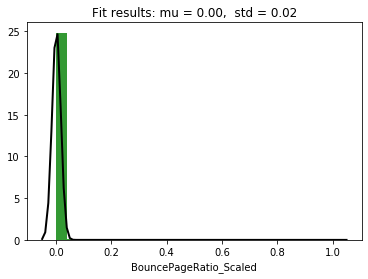

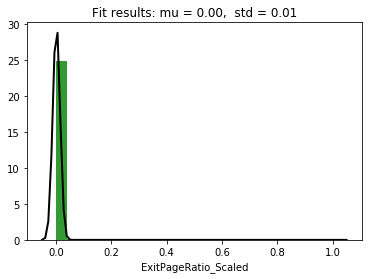

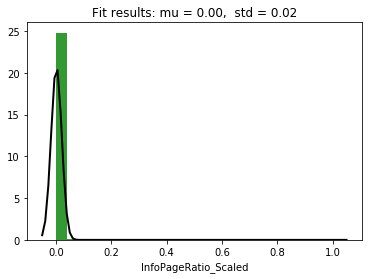

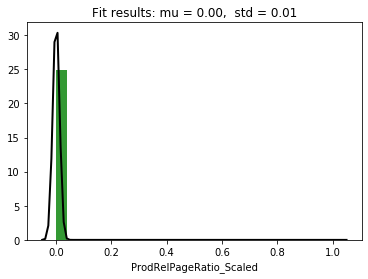

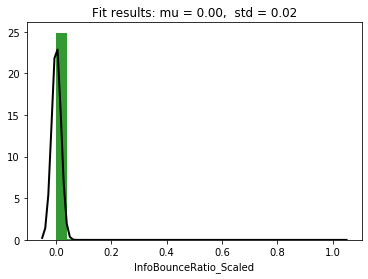

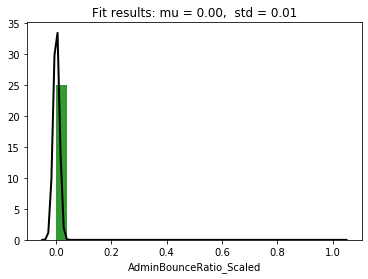

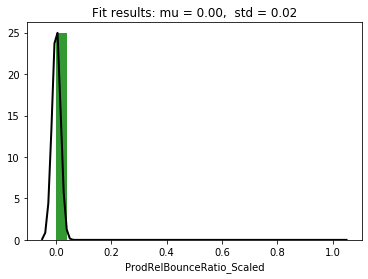

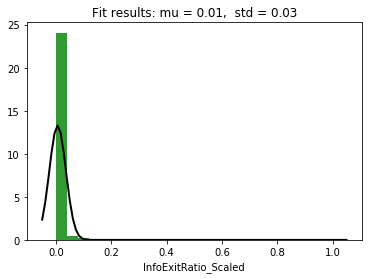

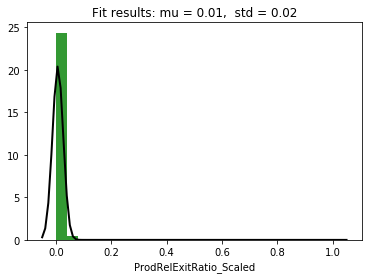

In [14]:
for col in normalization_df_cols:
    plot_hist(normalization_df, col)

### Applying Normalization

In [15]:
# innitial yeo-johnson normalization
for col in normalization_needed:
    if normalization_df[col].skew() > 0.5:
        normalization_df[col] = stats.yeojohnson(normalization_df[col])[0]
    
# replace -0 with 0 
normalization_df = normalization_df.replace(-0, 0)

# square-root transformation for positively/rightly skewed features that still have a skew > 0.5 
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        normalization_df[col] = np.sqrt(normalization_df[col])
        
# left skew transformation
normalization_df['totalFracProd_Scaled'] = normalization_df['totalFracProd_Scaled']**2

# right manual transformation
normalization_df['AdminBounceRatio_Scaled'] = np.sqrt(normalization_df['AdminBounceRatio_Scaled'])
normalization_df['ProdRelBounceRatio_Scaled'] = np.sqrt(np.sqrt(normalization_df['ProdRelBounceRatio_Scaled']))

### Skew after normalization

In [16]:
not_normalized = []
# if still not normal display 
for col in normalization_df_cols:
    if normalization_df[col].skew() > 0.5:
        print('Right skew: ',col,normalization_df[col].skew())
        not_normalized.append(col)
    elif normalization_df[col].skew() < -0.5:
        print('Left skew: ',col,normalization_df[col].skew())
        not_normalized.append(col)
    else:
         print('Normalized', col,normalization_df[col].skew())

Normalized Administrative_Duration_Scaled 0.3295801795635637
Right skew:  Informational_Duration_Scaled 1.7326012884342452
Normalized ProductRelated_Duration_Scaled -0.23543933031636485
Normalized BounceRates_Scaled 0.3262257513950875
Normalized ExitRates_Scaled 0.3379450817642422
Right skew:  PageValues_Scaled 1.4692374319742973
Normalized ExitRatesImpute_Scaled 0.34543199073436326
Normalized totalFracAdmin_Scaled 0.15463883173278434
Right skew:  totalFracInfo_Scaled 1.4670525404458559
Left skew:  totalFracProd_Scaled -1.5358710010478271
Normalized BounceExitAvg_Scaled -0.14021732571738893
Normalized BounceExitW1_Scaled -0.06154026184381935
Normalized BounceExitW2_Scaled 0.036799663481299594
Normalized BounceExitW3_Scaled 0.4776758903657082
Normalized BounceExitW4_Scaled 0.43335849977275076
Right skew:  BouncePageRatio_Scaled 2.4608667487409366
Right skew:  ExitPageRatio_Scaled 1.6922979051299853
Right skew:  InfoPageRatio_Scaled 3.3982797233166844
Right skew:  ProdRelPageRatio_Scaled

In [17]:
print('Number of features that were not normalized: ',len(not_normalized))
print('Number of features that were normalized: ', len(normalization_needed) - len(not_normalized))

Number of features that were not normalized:  10
Number of features that were normalized:  14


### Checking distribution of features 10 features not fully normalized 
- they look almost binary (contain a lot of zero-values) 
- we will create new features by binning them on some threshold (e.g. zero or not)

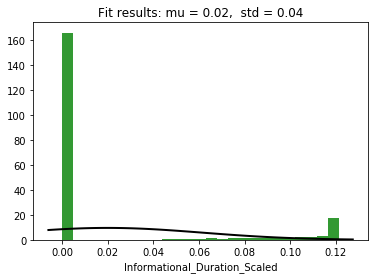

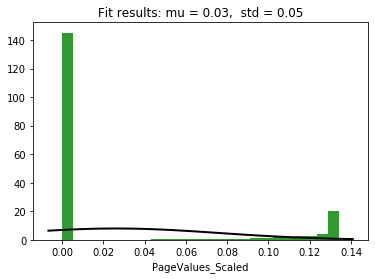

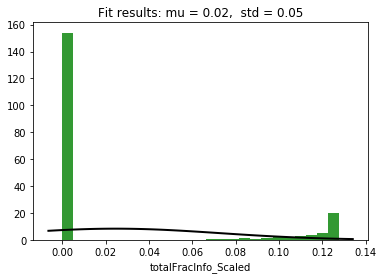

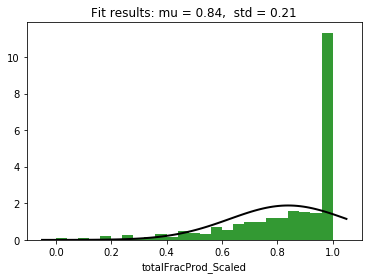

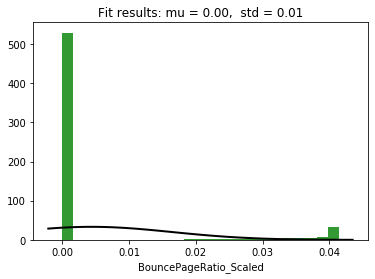

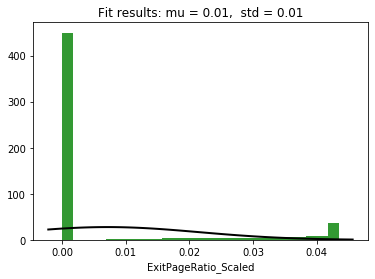

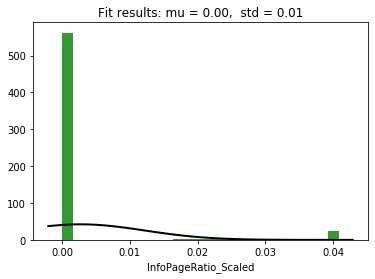

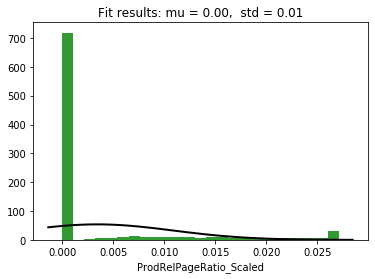

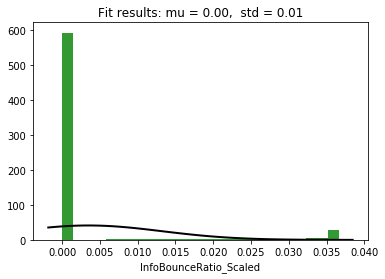

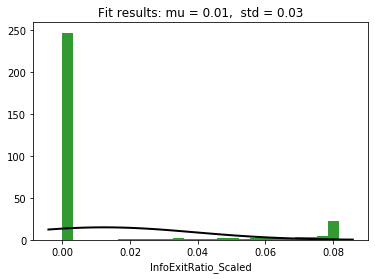

In [18]:
for col in not_normalized:
    plot_hist(normalization_df, col)

### Most frequent values for not fully normalized features
- are moslty zeroes so we will bin them depending on whether the value is a zero or not
- more zeroes occur in ratios as zero-division can be encountered 

In [19]:
for col in not_normalized:
    print(col, '\n',normalization_df[col].value_counts().head(1))

Informational_Duration_Scaled 
 0.0    9925
Name: Informational_Duration_Scaled, dtype: int64
PageValues_Scaled 
 0.0    9600
Name: PageValues_Scaled, dtype: int64
totalFracInfo_Scaled 
 0.0    9699
Name: totalFracInfo_Scaled, dtype: int64
totalFracProd_Scaled 
 1.0    5299
Name: totalFracProd_Scaled, dtype: int64
BouncePageRatio_Scaled 
 0.0    10792
Name: BouncePageRatio_Scaled, dtype: int64
ExitPageRatio_Scaled 
 0.0    9637
Name: ExitPageRatio_Scaled, dtype: int64
InfoPageRatio_Scaled 
 0.0    11315
Name: InfoPageRatio_Scaled, dtype: int64
ProdRelPageRatio_Scaled 
 0.0    9600
Name: ProdRelPageRatio_Scaled, dtype: int64
InfoBounceRatio_Scaled 
 0.0    10699
Name: InfoBounceRatio_Scaled, dtype: int64
InfoExitRatio_Scaled 
 0.0    9932
Name: InfoExitRatio_Scaled, dtype: int64


### Add suffix and merge with Data1
- add suffix to columns that needed normalization even the ones that could not be fully normalized

In [20]:
for col in normalization_needed: # All needed normalization 
    normalization_done = normalization_df.add_suffix('_Norm') # add suffix to distinguish 

In [21]:
# concat normalized features with scaled and original
data1 = pd.concat([data1,normalization_done], axis = 1)

In [22]:
# we now have 84 columns 
data1.shape

(12330, 84)

## Binning and Encoding
1. Bin and encode original categorical and text data
    - Bin month to quarters and one-hot 
    - Encode visitor type to numeric and one-hot
    - One-hot special day 
    - Convert to correct data type
2. Bin not fully normalized features

In [23]:
#1. Bin and encode original categorical and text data

#binning the Month column by quarter(as seen above)
#new column created-month_bin will have months binned by their respective quarters
def Month_bin(Month) :
    if Month == 'Jan':
        return 1
    elif Month == 'Feb':
        return 1
    elif Month == 'Mar':
        return 1
    elif Month == 'Apr':
        return 2
    elif Month == 'May':
        return 2
    elif Month == 'June':
        return 2
    elif Month == 'Jul':
        return 3
    elif Month == 'Aug':
        return 3
    elif Month == 'Sep':
        return 3
    elif Month == 'Oct':
        return 4
    elif Month == 'Nov':
        return 4
    elif Month == 'Dec':
        return 4

data1['Month_bin'] = data1['Month'].apply(Month_bin)

#binning VisitorType
#creating new column--VisitorType_bin
def VisitorType_bin(VisitorType) :
    if VisitorType == 'Returning_Visitor':
        return 1
    elif VisitorType == 'New_Visitor':
        return 2
    elif VisitorType == 'Other':
        return 3

# apply function
data1['VisitorType_bin'] = data1['VisitorType'].apply(VisitorType_bin)

# get dummies 
data1 = pd.get_dummies(data1, columns=['VisitorType_bin','Month_bin','SpecialDay'])
# convert to bool 
data1[['VisitorType_bin_1', 'VisitorType_bin_2', 'VisitorType_bin_3',
       'Month_bin_1', 'Month_bin_2', 'Month_bin_3', 'Month_bin_4','SpecialDay_0.0', 'SpecialDay_0.2',
       'SpecialDay_0.4', 'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0']] =  data1[['VisitorType_bin_1', 
    'VisitorType_bin_2', 'VisitorType_bin_3','Month_bin_1', 'Month_bin_2', 'Month_bin_3', 'Month_bin_4','SpecialDay_0.0',
    'SpecialDay_0.2','SpecialDay_0.4', 'SpecialDay_0.6', 'SpecialDay_0.8', 'SpecialDay_1.0']].astype(bool)

def browser_fun(series):
    if series == 2 or series == 1:
        return 1
    elif series == 4 or series == 5 or series == 6 or series == 10 or series == 8 or series == 3:
        return 2 
    else:
        return 3
    
# apply function for browser
data1['Browser_Bin'] = data1['Browser'].apply(browser_fun)

def TrafficType_fun(series):
    if series == 2 or series == 1 or series == 3 or series == 4:
        return 1
    elif series == 13 or series == 10 or series == 6 or series == 8 or series == 5 or series == 11 or series == 20:
        return 2 
    else:
        return 3
    
# apply function for TrafficType
data1['TrafficType_Bin'] = data1['TrafficType'].apply(TrafficType_fun)

def RegionFun(series):
    if series == 1 or series == 3:
        return 1
    elif series == 4 or series == 2:
        return 2 
    else:
        return 3
    
# apply function for Region
data1['Region_Bin'] = data1['Region'].apply(RegionFun)

def OperatingSystemsFun(series):
    if series == 2:
        return 1
    elif series == 1 or series == 3:
        return 2
    else:
        return 3

# apply function for TrafficType
data1['OperatingSystems_Bin'] = data1['OperatingSystems'].apply(OperatingSystemsFun)

data1 = pd.get_dummies(data1, columns=['Browser_Bin','TrafficType_Bin','Region_Bin','OperatingSystems_Bin'])

# convert to bool 
data1[['Browser_Bin_1','Browser_Bin_2','Browser_Bin_3','TrafficType_Bin_1','TrafficType_Bin_2','TrafficType_Bin_3',
'Region_Bin_1','Region_Bin_2','Region_Bin_3','OperatingSystems_Bin_1','OperatingSystems_Bin_2',
'OperatingSystems_Bin_3']] = data1[['Browser_Bin_1','Browser_Bin_2','Browser_Bin_3','TrafficType_Bin_1','TrafficType_Bin_2','TrafficType_Bin_3',
'Region_Bin_1','Region_Bin_2','Region_Bin_3','OperatingSystems_Bin_1','OperatingSystems_Bin_2',
'OperatingSystems_Bin_3']].astype(bool)

In [24]:
# 2. Bin not fully normalized features
# if it has some value return 1 otherwise 0
def zero_or_not(series):
    if series == 0:
        return 0
    else:
        return 1

# apply function
not_normalized.pop(3) # remove left skew feature from the list
for col in not_normalized: 
    data1[col+'_Bin'] = data1[col].apply(zero_or_not)
    # conver to bool (occupies less space than int)
    data1[col+'_Bin'] = data1[col+'_Bin'].astype(bool)

# function for the left skewed feature
def left_skew(series):
    if series >= 0.4:
        return 1
    else:
        return 0
    
# convert to bool
data1['totalFracProd_Bin'] = data1['totalFracProd_Scaled'].apply(left_skew).astype(bool)

In [25]:
print("Data shape: ", data1.shape)
print("Nbr dtype integer: ", len(data1.select_dtypes(include='int64').columns))
print("Nbr dtype float: ", len(data1.select_dtypes(include='float64').columns))
print("Nbr dtype bool: ", len(data1.select_dtypes(include='bool').columns))
print("Nbr dtype object: ", len(data1.select_dtypes(include='object').columns))

Data shape:  (12330, 118)
Nbr dtype integer:  7
Nbr dtype float:  72
Nbr dtype bool:  37
Nbr dtype object:  2


# Merge Pipeline A and Pipeline B 

In [28]:
# drop original/unprocessed/object columns 
pipeline_A = data1.drop(['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration',
    'BounceRates','ExitRates','PageValues','Month','VisitorType','ExitRatesImpute','totalFracAdmin','totalFracInfo',
    'totalFracProd','BounceExitAvg','BounceExitW1','BounceExitW2','BounceExitW3','BounceExitW4','BouncePageRatio',
    'ExitPageRatio','InfoPageRatio','ProdRelPageRatio','InfoBounceRatio','AdminBounceRatio',
    'ProdRelBounceRatio','InfoExitRatio','ProdRelExitRatio', 'Browser','Region','TrafficType','Region','OperatingSystems'],
        axis=1)

# Read in Data
pipeline_B = pd.read_csv('model_data_B.csv', index_col = 0)
pipeline_B = pipeline_B.select_dtypes(include = ['float64']).drop(['Administrative_Duration_Norm', 
        'Informational_Duration_Norm',
       'ProductRelated_Duration_Norm', 'BounceRates_Norm', 'ExitRates_Norm',
       'PageValues_Norm', 'ExitRatesImpute_Norm', 'totalFracAdmin_Norm',
       'totalFracInfo_Norm', 'totalFracProd_Norm', 'BounceExitAvg_Norm',
       'BounceExitW1_Norm', 'BounceExitW2_Norm', 'BounceExitW3_Norm',
       'BounceExitW4_Norm', 'BouncePageRatio_Norm', 'ExitPageRatio_Norm',
       'InfoPageRatio_Norm', 'ProdRelPageRatio_Norm', 'InfoBounceRatio_Norm',
       'AdminBounceRatio_Norm', 'ProdRelBounceRatio_Norm',
       'InfoExitRatio_Norm', 'ProdRelExitRatio_Norm'], axis = 1)

# MERGE
model_data = pd.concat([pipeline_A,pipeline_B], axis = 1)


# select X and y 
X = model_data.drop('Revenue', axis =1) #features
x_col = model_data.drop('Revenue', axis =1)
y = model_data['Revenue'] #target
feature_name = X.columns.tolist()

# save preprocessed data
model_data.to_csv('all_model_data.csv')

# nbr of rows, nbr of columns 
print(model_data.shape)
print(X.shape) # features
print(y.shape) # label/target

(12330, 109)
(12330, 108)
(12330,)


In [30]:
model_data = pd.read_csv('all_model_data.csv', index_col = 0)
#model_data.head()

## 10 Way Feature Selection
- select 50 features from 136
- xxx_support: list to represent select this feature or not
- xxx_feature: the name of selected features

### Methods:
1. Filter: Pearson, f_classif (Anova F value)
2. Wrapper: RFE with Logistic regression and XGBoost
3. Embeded: Logistic Regression, Random Forest, XGBoost, LassoCV, RidgeClassifierCV

Source of Inspiration and modified: https://www.kaggle.com/sz8416/6-ways-for-feature-selection

In [31]:
# select X and y 
X = model_data.drop('Revenue', axis = 1)
feature_name = X.columns.tolist()
y = model_data.Revenue

### 1 Filter
#### 1.1 Pearson Correlation

In [32]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-50:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [33]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

50 selected features


#### 1.2 f_classif
- documentation for SelectKBest: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
f_classif_selector = SelectKBest(f_classif, k=50)
f_classif_selector.fit(X, y)

SelectKBest(k=50, score_func=<function f_classif at 0x7f86e9f6b158>)

In [35]:
f_classif_support = f_classif_selector.get_support()
f_classif_feature = X.loc[:,f_classif_support].columns.tolist()
print(str(len(f_classif_feature)), 'selected features')

50 selected features


#### 2. Wrapper
- documentation for RFE: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
- logistic regression and xgboost

#### 2.1 RFE - Logistic Regression<br>
RFE notes:
- estimator = means what model to estimate it on
- max_iter = if model doesn't converge, random state for reusability 
- step =  how many observation to remove after each iteration 
- verbose = can get more visual output (doesn't change the model)

In [36]:
# packages you would need 
#from sklearn.feature_selection import RFE
#from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(max_iter = 1500,random_state=123), step = 10, n_features_to_select=50,
                   verbose=0)
rfe_selector.fit(X, y)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=1500,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=123, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=50, step=10, verbose=0)

In [37]:
rfe_support = rfe_selector.get_support() # Get a mask, or integer index, of the features selected
rfe_feature = X.loc[:,rfe_support].columns.tolist() # get the column names of features selected and put them in a list
print(str(len(rfe_feature)), 'selected features') 

50 selected features


#### 2.2 RFE XGBOOST

In [38]:
rfe_selector_xgboost = RFE(estimator=XGBClassifier(random_state=123), n_features_to_select=50, step=10, verbose=0)
rfe_selector_xgboost.fit(X, y)

RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                            colsample_bylevel=1, colsample_bynode=1,
                            colsample_bytree=1, gamma=0, learning_rate=0.1,
                            max_delta_step=0, max_depth=3, min_child_weight=1,
                            missing=None, n_estimators=100, n_jobs=1,
                            nthread=None, objective='binary:logistic',
                            random_state=123, reg_alpha=0, reg_lambda=1,
                            scale_pos_weight=1, seed=None, silent=None,
                            subsample=1, verbosity=1),
    n_features_to_select=50, step=10, verbose=0)

In [39]:
# transform
rfe_support_xgboost = rfe_selector_xgboost.get_support()
rfe_feature_xgboost = X.loc[:,rfe_support_xgboost].columns.tolist()
print(str(len(rfe_support_xgboost)), 'selected features')

108 selected features


### 3. Embeded
- documentation for SelectFromModel: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html 

#### 3.1 Logistics Regression 

In [40]:
from sklearn.feature_selection import SelectFromModel
#from sklearn.linear_model import LogisticRegression
# penalty l2 is default (regularization type for solver)
# threshold = minimum threshold applied (applied so it selects approx 50 features )
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2", random_state = 123, max_iter=1000), threshold = 0.2)
embeded_lr_selector.fit(X, y)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=1000, multi_class='auto',
                                             n_jobs=None, penalty='l2',
                                             random_state=123, solver='lbfgs',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=0.2)

In [41]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

50 selected features


#### 3.2 Random Forest

In [73]:
#from sklearn.feature_selection import SelectFromModel
#from sklearn.ensemble import RandomForestClassifier
# n_estimators = The number of trees in the forest (10-100)
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=50, random_state = 123), threshold=0.00775)
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=50, n_jobs=None,
                                                 oob_score=False,


In [74]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

50 selected features


#### 3.3 XGBoost

In [81]:
embeded_xgb_selector = SelectFromModel(XGBClassifier(n_estimators=50, random_state = 123))
embeded_xgb_selector.fit(X, y)

SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                        colsample_bylevel=1, colsample_bynode=1,
                                        colsample_bytree=1, gamma=0,
                                        learning_rate=0.1, max_delta_step=0,
                                        max_depth=3, min_child_weight=1,
                                        missing=None, n_estimators=50, n_jobs=1,
                                        nthread=None,
                                        objective='binary:logistic',
                                        random_state=123, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1,
                                        seed=None, silent=None, subsample=1,
                                        verbosity=1),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [82]:
embeded_xgb_support = embeded_xgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

22 selected features


### 3.4 LassoCV
- Lasso linear model with iterative fitting along a regularization path (built-in cross validation)
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [89]:
from sklearn.linear_model import LassoCV
# cv = number of k for cross validation 
embeded_lasso_selector = SelectFromModel(LassoCV(random_state = 123, cv = 10, max_iter = 2000),threshold = 0.0001)
embeded_lasso_selector.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001,
                                  fit_intercept=True, max_iter=2000,
                                  n_alphas=100, n_jobs=None, normalize=False,
                                  positive=False, precompute='auto',
                                  random_state=123, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=None, norm_order=1, prefit=False,
                threshold=0.0001)

In [90]:
embeded_lasso_support = embeded_lasso_selector.get_support()
embeded_lasso_feature = X.loc[:,embeded_lasso_support].columns.tolist()
print(str(len(embeded_lasso_feature)), 'selected features')

41 selected features


### 3.5 Ridge Classifier CV
- Ridge classifier with built-in cross-validation
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html#sklearn.linear_model.RidgeClassifierCV

In [101]:
from sklearn.linear_model import RidgeClassifierCV
embeded_ridge_selector = SelectFromModel(RidgeClassifierCV(cv=10), threshold =0.059)
embeded_ridge_selector.fit(X, y)

SelectFromModel(estimator=RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]),
                                            class_weight=None, cv=10,
                                            fit_intercept=True, normalize=False,
                                            scoring=None,
                                            store_cv_values=False),
                max_features=None, norm_order=1, prefit=False, threshold=0.059)

In [102]:
embeded_ridge_support = embeded_ridge_selector.get_support()
embeded_ridge_feature = X.loc[:,embeded_ridge_support].columns.tolist()
print(str(len(embeded_ridge_feature)), 'selected features')

50 selected features


### 3.6 Linear SVC
- https://scikit-learn.org/stable/modules/feature_selection.html

In [110]:
from sklearn.svm import LinearSVC
embeded_svc_selector = SelectFromModel(LinearSVC(C=0.5, penalty='l1', dual=False, max_iter = 5000),threshold = 0.001)
embeded_svc_selector.fit(X, y)

embeded_svc_support = embeded_svc_selector.get_support()
embeded_svc_feature = X.loc[:,embeded_svc_support].columns.tolist()
print(str(len(embeded_svc_feature)), 'selected features')

50 selected features


/opt/tljh/user/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## Summary
- Contains features that were derived from similar features 
- When modeling only one version (better one should be used)

In [111]:
pd.set_option('display.max_rows', 100)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support,'f_classif':f_classif_support,
    'RFE-Log':rfe_support,'RFE-XGBoost': rfe_support_xgboost,'Logistics':embeded_lr_support,'LassoCV':embeded_lasso_support,
    'RidgeClassifierCV':embeded_ridge_support,'Random Forest':embeded_rf_support,'XGBoost':embeded_xgb_support,
    'LinearSVC':embeded_svc_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 65
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(65)

,Feature,Pearson,f_classif,RFE-Log,RFE-XGBoost,Logistics,LassoCV,RidgeClassifierCV,Random Forest,XGBoost,LinearSVC,Total
1,ProductRelated_Duration_Scaled,True,True,True,True,True,False,True,True,True,True,9
2,PageValues_Norm_Scaled,True,True,True,True,True,True,True,True,False,True,9
3,ExitPageRatio_Norm_Scaled,True,True,True,True,True,True,True,True,False,True,9
4,BounceRates_Scaled,True,True,True,True,True,True,True,True,True,False,9
5,BouncePageRatio_Norm_Scaled,True,True,True,True,True,True,True,True,False,True,9
6,BounceExitW4_Norm_Scaled,True,True,True,True,True,True,True,True,False,True,9
7,ProductRelated_Duration_Norm_Scaled,True,True,True,False,True,True,True,True,False,True,8
8,ProdRelPageRatio_Scaled_Bin,True,True,True,False,True,True,True,True,False,True,8
9,ProdRelExitRatio_Norm_Scaled,True,True,True,False,True,True,True,True,False,True,8
10,PageValues_Scaled_Bin,True,True,True,False,True,True,True,True,False,True,8


In [112]:
feature_selection_df.to_csv('feature_selection.csv')